# LOAD

In [1]:
from load import load_data

In [2]:
X, y = load_data('../data/creditcard.csv', resp= 'Class')

In [3]:
X.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62
1,0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69
2,1,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66


In [4]:
y.head(3)

0    0.0
1    0.0
2    0.0
Name: Class, dtype: float64

# EDA 

In [4]:
import visualiser as v 

eda_plots = v.visualiser(X= X, y= y)

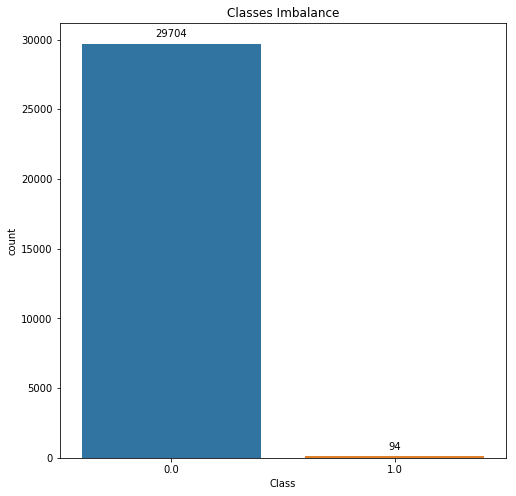

In [6]:
eda_plots.class_imbalance()

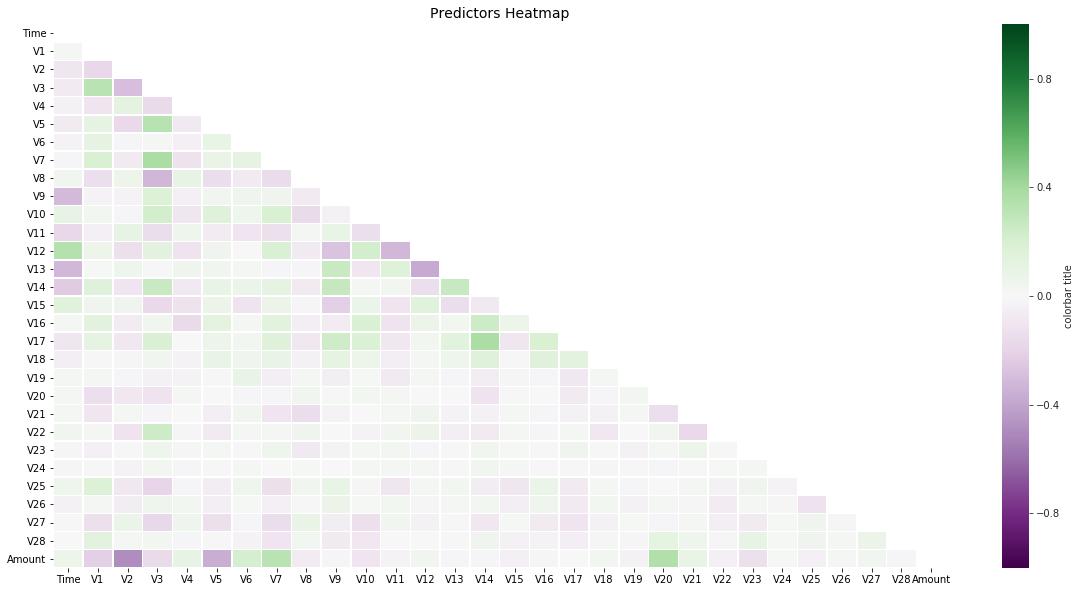

In [7]:
eda_plots.corr_heatmap()

# PRE-PROCESSING

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size= .2, random_state= 1 )

In [13]:
y_train.describe()

count    23838.000000
mean         0.003104
std          0.055631
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: Class, dtype: float64

# MODEL

In [5]:
%%time
from xgboost import XGBClassifier

model = XGBClassifier().fit(X_train, y_train)
y_pred = model.predict(X_test)

CPU times: user 4.3 s, sys: 7.73 ms, total: 4.3 s
Wall time: 4.3 s


# ASSESSMENT

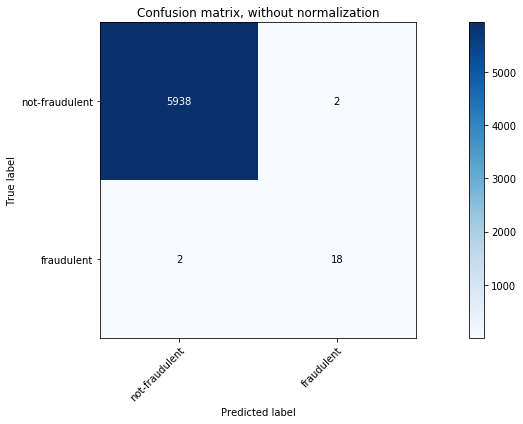

In [23]:
assess = v.visualiser(X= X_test, y= y_test)
assess.confusion_matrix(y_pred= y_pred, classes= ['not-fraudulent', 'fraudulent'])

In [24]:
assess.f1( y_pred)

F1 score is: 0.9


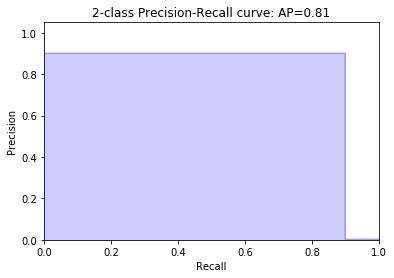

In [25]:
assess.areaUnderPR( y_pred)

# Under-sampling

In [63]:
# from imblearn.under_sampling import RandomUnderSampler

# rus = RandomUnderSampler(random_state= 1)
# X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [10]:
from imblearn.under_sampling import ClusterCentroids
from sklearn.cluster import KMeans
import pandas as pd

def KMeansUnderSample( X_train, y_train , shrink ): 
    '''
        Creates new majority class by clustering the existing. 
        The class is shrunk according to the "shrink" parameter.
    '''
    if type(y_train) != pd.core.series.Series: # type check to be abe to us VALUE_COUNTS
        y_train = pd.Series( y_train )
    Nmin = y_train.value_counts()[1] # minority class count
    NmajR = y_train.value_counts()[0]/ shrink # NEW majority class count
    strategy = Nmin/NmajR
    # under-sample only the majority class. Substitute with the centorids
    cc = ClusterCentroids(random_state= 1, sampling_strategy= strategy, voting= 'soft', estimator= KMeans( n_clusters = NmajR ))
    return cc.fit_sample(X_train, y_train)

In [11]:
%%time
X_res, y_res = KMeansUnderSample(X_train, y_train, shrink= 5)

CPU times: user 16min 24s, sys: 8min 56s, total: 25min 21s
Wall time: 5min 46s


In [12]:
%%time
from xgboost import XGBClassifier

model = XGBClassifier().fit(X_res, y_res)
y_pred = model.predict(X_test.values)

CPU times: user 755 ms, sys: 0 ns, total: 755 ms
Wall time: 753 ms


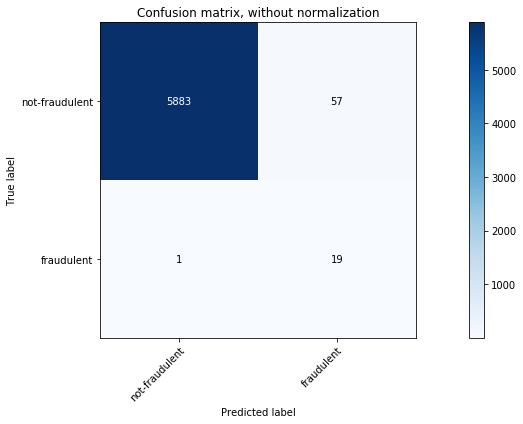

In [13]:
assessKM = v.visualiser(X= X_test, y= y_test)
assessKM.confusion_matrix(y_pred= y_pred, classes= ['not-fraudulent', 'fraudulent'])

In [14]:
assessKM.f1( y_pred)

F1 score is: 0.3958333333333333


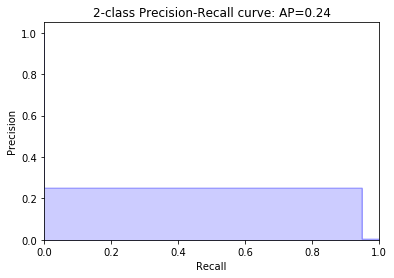

In [15]:
assessKM.areaUnderPR( y_pred)